## Plot DELWAQ data

**hydroMT** provides a simple interface to model schematization from which we can make beautiful plots:

- Raster layers are saved to the model `staticmaps` attribute as a  `xarray.Dataset`
- Vector layers are saved to the model `staticgeoms` attribute as a `geopandas.GeoDataFrame`. Note that in case of DELWAQ these are not used by the model engine, but only for analysis and visualization purposes.
- Extracts from the linked hydrologic/hydrualic/hydrodynamic model are saved to the model `hydromaps` attribute as `xarray.Dataset`. In the case of DELWAQ they are not used by the engine but can be useful for post-processing.

We use the [cartopy](https://scitools.org.uk/cartopy/docs/latest/) package to plot maps. This packages provides a simple interface to plot geographic data and add background satellite imagery.

### Load dependencies

In [1]:
import pandas as pd
import xarray as xr
import numpy as  np
from os.path import join, dirname
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

In [2]:
import hydromt

### Read the model

In [3]:
root = 'EM_piave' 
mod = hydromt.DelwaqModel(root, mode='r')

### Plot model schematization base maps

Here we plot the model basemaps (Segment ID map with basins, monitoring points and areas geometries). 

In [4]:
# plot maps dependencies
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import descartes # required to plot polygons
import cartopy.io.img_tiles as cimgt

In [5]:
# read and mask the model elevation
da =mod.hydromaps['ptid'].raster.mask_nodata()
da.attrs.update(long_name='segment ID', units='-')
# read/derive model basin boundary
gdf_bas = mod.basins

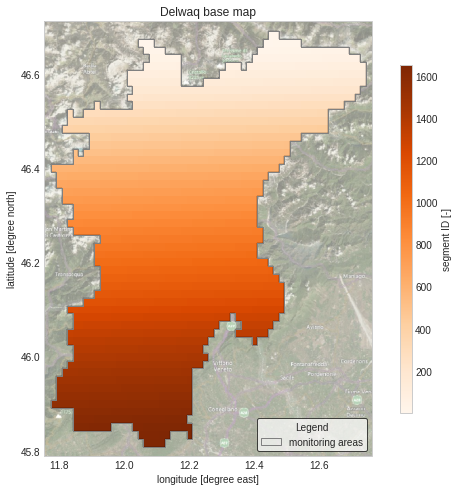

In [6]:
plt.style.use('seaborn-whitegrid') # set nice style
# we assume the model maps are in the geographic CRS EPSG:4326
proj = ccrs.PlateCarree()
# adjust zoomlevel and figure size to your basis size & aspect
zoom_level = 10
figsize=(10, 8)
shaded= False # shaded elevation (looks nicer with more pixels (e.g.: larger basins))!


# initialize image with geoaxes
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(projection=proj)
extent = np.array(da.raster.box.buffer(0.02).total_bounds)[[0, 2, 1, 3]]
ax.set_extent(extent, crs=proj)

# add sat background image
ax.add_image(cimgt.QuadtreeTiles(), zoom_level, alpha=0.5)

## plot ptid
cmap = plt.cm.get_cmap('Oranges')
kwargs = dict(cmap=cmap)
# plot 'normal' elevation
da.plot(transform=proj, ax=ax, zorder=1, cbar_kwargs=dict(aspect=30, shrink=.8), **kwargs)
                
# plot the basin boundary
gdf_bas.boundary.plot(ax=ax, color='k', linewidth=0.3)
# plot various vector layers if present
if 'monpoints' in mod.staticgeoms:
    mod.staticgeoms['monpoints'].plot(ax=ax, marker='d', markersize=25, facecolor='k', zorder=5, label='monitoring points')
patches = [] # manual patches for legend, see https://github.com/geopandas/geopandas/issues/660
if 'monareas' in mod.staticgeoms:
    kwargs = dict(facecolor='None', edgecolor='grey', label='monitoring areas')
    mod.staticgeoms['monareas'].plot(ax=ax, zorder=4, **kwargs)
    patches.append(mpatches.Patch(**kwargs))
    
ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.set_ylabel(f"latitude [degree north]")
ax.set_xlabel(f"longitude [degree east]")
_ = ax.set_title(f"Delwaq base map")
legend = ax.legend(
    handles=[*ax.get_legend_handles_labels()[0], *patches],
    title="Legend",
    loc='lower right',
    frameon=True,
    framealpha=0.7,
    edgecolor='k',
    facecolor='white'
)

# save figure
# NOTE create figs folder in model root if it does not exist
# fn_out = join(mod.root, "figs", "basemap.png")
# plt.savefig(fn_out, dpi=225, bbox_inches="tight")

### Plot model emission maps

Here we plot the model staticmaps (emission maps).

In [7]:
#List of available emission data in the model
print(f"Available emision data: {list(mod.staticmaps.keys())}")

Available emision data: ['streamorder', 'slope', 'monareas', 'GHS-POP_2015', 'GHS-SMOD_2015', 'GDP_world']


Use the code below to plot the different available emission data. You can also change the colors by using available colormaps from [matplotlib](https://matplotlib.org/stable/tutorials/colors/colormaps.html).

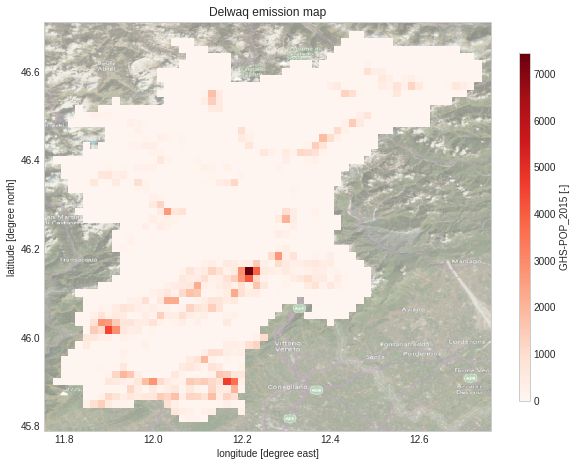

In [8]:
# Edit the lines below to change the emission map and its colormap
emissionmap = 'GHS-POP_2015'
colormap = 'Reds'

#Load the emission map
da = mod.staticmaps[emissionmap].raster.mask_nodata()
da.attrs.update(long_name=emissionmap, units='-')

#Plot
plt.style.use('seaborn-whitegrid') # set nice style
# we assume the model maps are in the geographic CRS EPSG:4326
proj = ccrs.PlateCarree()
# adjust zoomlevel and figure size to your basis size & aspect
zoom_level = 10
figsize=(10, 8)

# initialize image with geoaxes
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(projection=proj)
extent = np.array(da.raster.box.buffer(0.02).total_bounds)[[0, 2, 1, 3]]
ax.set_extent(extent, crs=proj)

# add sat background image
ax.add_image(cimgt.QuadtreeTiles(), zoom_level, alpha=0.5)

## plot emission map
cmap = plt.cm.get_cmap(colormap)
kwargs = dict(cmap=cmap)
# plot 'normal' elevation
da.plot(transform=proj, ax=ax, zorder=1, cbar_kwargs=dict(aspect=30, shrink=.8), **kwargs)

ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.set_ylabel(f"latitude [degree north]")
ax.set_xlabel(f"longitude [degree east]")
_ = ax.set_title(f"Delwaq emission map")